In [3]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# # 1. 读取数据
# data = pd.read_csv(r'D:\bindingDB\催化亚基\选择性催化亚基组合.csv', encoding='gbk')  # 替换为你的文件路径
# # data = pd.read_excel(r'C:\Users\RANSHAO\Untitled Folder\data\多亚型11训练集.xlsx') 
# # 2. 数据预处理
# # 转换SMILES为特征向量
# def smiles_to_features(smiles_list):
#     features = []
#     for smi in smiles_list:
#         mol = Chem.MolFromSmiles(smi)
#         if mol is not None:
#             fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
#             features.append(np.array(fp))
#         else:
#             features.append(np.zeros(2048))
#     return np.array(features)

# X = smiles_to_features(data['smiles'])




In [4]:
data = pd.read_csv(r'D:\分类数据\去重催化分类内部数据集.csv', encoding='gbk')

In [5]:
def smiles_to_features(smiles_list):
    features = []
    for smi in smiles_list:
        # 跳过无效的 SMILES（例如 NaN 或 float）
        if isinstance(smi, str):
            mol = Chem.MolFromSmiles(smi)
            if mol is not None:
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
                features.append(fp)
            else:
                features.append(np.zeros(2048))  # 对无效的 SMILES 使用零向量
        else:
            features.append(np.zeros(2048))  # 对非字符串值使用零向量
    return np.array(features)
X = smiles_to_features(data['smiles'])

[16:14:42] DEPRECATION WARNING: please use MorganGenerator
[16:14:42] DEPRECATION WARNING: please use MorganGenerator
[16:14:42] DEPRECATION WARNING: please use MorganGenerator
[16:14:42] DEPRECATION WARNING: please use MorganGenerator
[16:14:42] DEPRECATION WARNING: please use MorganGenerator
[16:14:42] DEPRECATION WARNING: please use MorganGenerator
[16:14:42] DEPRECATION WARNING: please use MorganGenerator
[16:14:42] DEPRECATION WARNING: please use MorganGenerator
[16:14:42] DEPRECATION WARNING: please use MorganGenerator
[16:14:42] DEPRECATION WARNING: please use MorganGenerator
[16:14:42] DEPRECATION WARNING: please use MorganGenerator
[16:14:42] DEPRECATION WARNING: please use MorganGenerator
[16:14:42] DEPRECATION WARNING: please use MorganGenerator
[16:14:42] DEPRECATION WARNING: please use MorganGenerator
[16:14:42] DEPRECATION WARNING: please use MorganGenerator
[16:14:42] DEPRECATION WARNING: please use MorganGenerator
[16:14:42] DEPRECATION WARNING: please use MorganGenerat

In [6]:
# 标签编码
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['labels'])

In [7]:


# 输出编码后每个整数对应的原始标签
for i, label in enumerate(label_encoder.classes_):
    print(f"编码 {i}: 标签 '{label}'")

编码 0: 标签 'α'
编码 1: 标签 'αβγδ'
编码 2: 标签 'β'
编码 3: 标签 'βδ'
编码 4: 标签 'γ'
编码 5: 标签 'δ'


In [8]:
# 计算类别权重
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))

In [9]:




# 3. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 构建XGBoost模型并考虑类别权重
model = xgb.XGBClassifier(
    objective='multi:softprob', 
    num_class=len(np.unique(y)), 
    eval_metric='mlogloss',
    scale_pos_weight=class_weight_dict  # 使用类别权重
)

# 5. 模型训练
model.fit(X_train, y_train)


# 保存模型
joblib.dump(model, 'xgboost_model.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')




E:\anaconda\envs\AIDrugDesign\lib\site-packages\xgboost\core.py:158: UserWarning: [16:15:08] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


['label_encoder.pkl']

In [10]:
# 7. 输出训练集的分类报告
from sklearn.metrics import classification_report
y_pred_train = model.predict(X_train)
target_names = label_encoder.inverse_transform(np.unique(y))
report = classification_report(y_train, y_pred_train)
print(report)


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6378
           1       1.00      1.00      1.00       312
           2       0.95      0.98      0.96       196
           3       0.83      0.82      0.82        94
           4       0.97      0.90      0.93       638
           5       0.98      0.98      0.98      5088

    accuracy                           0.98     12706
   macro avg       0.95      0.94      0.95     12706
weighted avg       0.98      0.98      0.98     12706



In [11]:
# 6. 预测与测试集的分类报告
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
target_names = label_encoder.inverse_transform(np.unique(y))
report = classification_report(y_test, y_pred, target_names=target_names, digits=4)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           α     0.9378    0.9694    0.9534      1571
        αβγδ     1.0000    1.0000    1.0000        73
           β     0.9000    0.6545    0.7579        55
          βδ     0.7647    0.5909    0.6667        22
           γ     0.8571    0.7083    0.7757       144
           δ     0.9571    0.9512    0.9541      1312

    accuracy                         0.9427      3177
   macro avg     0.9028    0.8124    0.8513      3177
weighted avg     0.9417    0.9427    0.9413      3177



In [14]:
# from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
# # 6. 绘制AUC曲线
# plt.figure(figsize=(10, 8))
# classes = np.unique(y)
# for i, label in enumerate(classes):
#     fpr, tpr, _ = roc_curve((y_test == label).astype(int), y_pred_proba[:, i])
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label=f'Class {label} (AUC = {roc_auc:.4f})')

# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('AUC Curve for Each Class')
# plt.legend(loc='best')
# plt.grid()
# plt.show()

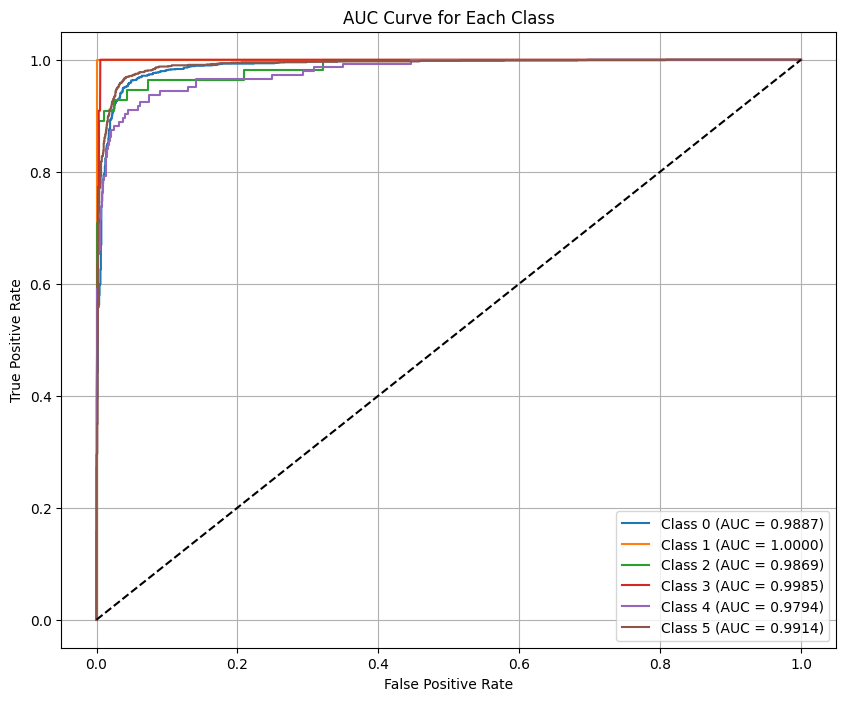

In [13]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import pandas as pd

# 6. 绘制AUC曲线
plt.figure(figsize=(10, 8))
classes = np.unique(y_test)  # 假设y_test是测试集的真实标签
roc_data_list = []  # 用于存储所有类别AUC曲线数据的列表

for i, label in enumerate(classes):
    fpr, tpr, _ = roc_curve((y_test == label).astype(int), y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    
    # 添加到绘图
    plt.plot(fpr, tpr, label=f'Class {label} (AUC = {roc_auc:.4f})')
    
    # 准备保存数据
    roc_data_list.append(pd.DataFrame({
        'FPR': fpr,
        'TPR': tpr,
        'AUC': [roc_auc] * len(fpr),
        'Class': [f'Class {label}'] * len(fpr)
    }))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve for Each Class')
plt.legend(loc='best')
plt.grid()
plt.show()

# 合并所有类别的AUC曲线数据
all_roc_data = pd.concat(roc_data_list, ignore_index=True)

# 将合并的数据保存为CSV文件
all_roc_data.to_csv('D:\毕设文件2025.3.13\XGB_Test_classes_roc_data.csv', index=False)

[16:43:22] DEPRECATION WARNING: please use MorganGenerator
[16:43:22] DEPRECATION WARNING: please use MorganGenerator
[16:43:22] DEPRECATION WARNING: please use MorganGenerator
[16:43:22] DEPRECATION WARNING: please use MorganGenerator
[16:43:22] DEPRECATION WARNING: please use MorganGenerator
[16:43:22] DEPRECATION WARNING: please use MorganGenerator
[16:43:22] DEPRECATION WARNING: please use MorganGenerator
[16:43:22] DEPRECATION WARNING: please use MorganGenerator
[16:43:22] DEPRECATION WARNING: please use MorganGenerator
[16:43:22] DEPRECATION WARNING: please use MorganGenerator
[16:43:22] DEPRECATION WARNING: please use MorganGenerator
[16:43:22] DEPRECATION WARNING: please use MorganGenerator
[16:43:22] DEPRECATION WARNING: please use MorganGenerator
[16:43:22] DEPRECATION WARNING: please use MorganGenerator
[16:43:22] DEPRECATION WARNING: please use MorganGenerator
[16:43:22] DEPRECATION WARNING: please use MorganGenerator
[16:43:22] DEPRECATION WARNING: please use MorganGenerat

Accuracy: 0.9432
Precision (Macro): 0.8182
Recall (Macro): 0.8612
F1 Score (Macro): 0.8320
Classification Report:
              precision    recall  f1-score   support

           α       0.94      0.96      0.95       883
        αβγδ       1.00      1.00      1.00        44
           β       0.60      0.75      0.67        28
          βδ       0.56      0.83      0.67        12
           γ       0.83      0.66      0.74        83
           δ       0.98      0.96      0.97       710

    accuracy                           0.94      1760
   macro avg       0.82      0.86      0.83      1760
weighted avg       0.95      0.94      0.94      1760

Confusion Matrix:
[[847   0  14   0   8  14]
 [  0  44   0   0   0   0]
 [  7   0  21   0   0   0]
 [  0   0   0  10   2   0]
 [ 25   0   0   1  55   2]
 [ 19   0   0   7   1 683]]


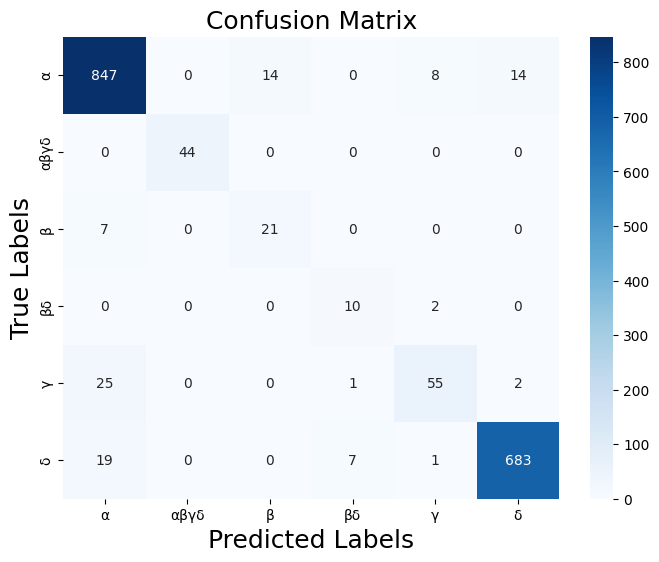

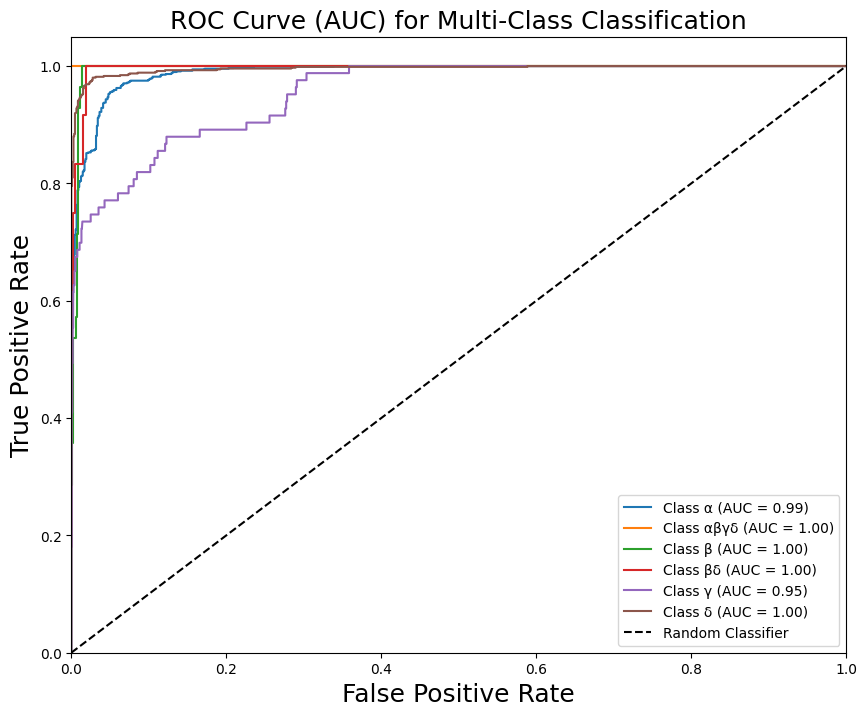

Results saved to D:\分类数据\XGboost推理能力.xlsx


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, auc
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import LabelBinarizer
from rdkit import Chem
from rdkit.Chem import AllChem

# SMILES 转特征的函数
def smiles_to_features(smiles_list):
    features = []
    for smi in smiles_list:
        # 跳过无效的 SMILES（例如 NaN 或 float）
        if isinstance(smi, str):
            mol = Chem.MolFromSmiles(smi)
            if mol is not None:
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
                features.append(fp)
            else:
                features.append(np.zeros(2048))  # 对无效的 SMILES 使用零向量
        else:
            features.append(np.zeros(2048))  # 对非字符串值使用零向量
    return np.array(features)

# 模型推理与结果保存
def model_inference(input_file, output_file):
    try:
        # 加载模型
        model = joblib.load('xgboost_model.pkl')
        label_encoder = joblib.load('label_encoder.pkl')

        # 读取输入数据
        inference_data = pd.read_excel(input_file)
        if 'smiles' not in inference_data.columns or 'labels' not in inference_data.columns:
            raise ValueError("输入文件必须包含 'smiles' 和 'labels' 列")

        smiles_list = inference_data['smiles']
        true_labels = inference_data['labels']

        # 转换SMILES为特征
        X_inference = smiles_to_features(smiles_list)

        # 预测
        y_pred = model.predict(X_inference)
        predicted_labels = label_encoder.inverse_transform(y_pred)

        # 计算性能指标
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels, average='macro')
        recall = recall_score(true_labels, predicted_labels, average='macro')
        f1 = f1_score(true_labels, predicted_labels, average='macro')
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (Macro): {precision:.4f}")
        print(f"Recall (Macro): {recall:.4f}")
        print(f"F1 Score (Macro): {f1:.4f}")
        print("Classification Report:")
        print(classification_report(true_labels, predicted_labels))

        # 混淆矩阵
        conf_matrix = confusion_matrix(true_labels, predicted_labels)
        print("Confusion Matrix:")
        print(conf_matrix)

        # 保存混淆矩阵数据
        cm_df = pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)
        cm_df.to_csv(r'D:\图数据\XGB_confusion_matrix.csv', index=True)

        # 绘制混淆矩阵图
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels', fontsize=18)
        plt.ylabel('True Labels', fontsize=18)
        plt.title('Confusion Matrix', fontsize=18)
        plt.savefig(r'D:\图数据\XGB_confusion_matrix.png', dpi=1000)
        plt.show()

        # ROC AUC（多分类）
        lb = LabelBinarizer()
        true_labels_bin = lb.fit_transform(true_labels)
        y_prob = model.predict_proba(X_inference)

        # 绘制每个类别的ROC曲线和AUC
        plt.figure(figsize=(10, 8))
        n_classes = y_prob.shape[1]
        fpr, tpr, roc_auc = {}, {}, {}

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], label=f'Class {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

            # 保存AUC曲线数据为CSV
            auc_df = pd.DataFrame({'FPR': fpr[i], 'TPR': tpr[i]})
            auc_df.to_csv(f'D:\图数据\XGB_roc_data_class_{lb.classes_[i]}.csv', index=False)

        # 画对角线（随机分类器）
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=18)
        plt.ylabel('True Positive Rate', fontsize=18)
        plt.title('ROC Curve (AUC) for Multi-Class Classification', fontsize=18)
        plt.legend(loc='lower right')

        # 保存高清AUC曲线图
        plt.savefig(r'D:\图数据\XGB_roc_curve.png', dpi=1000)
        plt.show()

        # 保存预测结果
        inference_data['Predicted Subtype'] = predicted_labels
        inference_data.to_excel(output_file, index=False)
        print(f"Results saved to {output_file}")

    except Exception as e:
        print(f"Error during inference: {e}")

# 示例推理调用
model_inference(r'D:\分类数据\0.1外部分类验证集.xlsx', r'D:\分类数据\XGboost推理能力.xlsx')


[16:24:14] DEPRECATION WARNING: please use MorganGenerator
[16:24:14] DEPRECATION WARNING: please use MorganGenerator
[16:24:14] DEPRECATION WARNING: please use MorganGenerator
[16:24:14] DEPRECATION WARNING: please use MorganGenerator
[16:24:14] DEPRECATION WARNING: please use MorganGenerator
[16:24:14] DEPRECATION WARNING: please use MorganGenerator
[16:24:14] DEPRECATION WARNING: please use MorganGenerator
[16:24:14] DEPRECATION WARNING: please use MorganGenerator
[16:24:14] DEPRECATION WARNING: please use MorganGenerator
[16:24:14] DEPRECATION WARNING: please use MorganGenerator
[16:24:14] DEPRECATION WARNING: please use MorganGenerator
[16:24:14] DEPRECATION WARNING: please use MorganGenerator
[16:24:14] DEPRECATION WARNING: please use MorganGenerator
[16:24:14] DEPRECATION WARNING: please use MorganGenerator
[16:24:14] DEPRECATION WARNING: please use MorganGenerator
[16:24:14] DEPRECATION WARNING: please use MorganGenerator
[16:24:14] DEPRECATION WARNING: please use MorganGenerat

Inference Accuracy: 0.9432
Precision (Macro): 0.8182
Recall (Macro): 0.8612
F1 Score (Macro): 0.8320
Classification Report:
              precision    recall  f1-score   support

           α       0.94      0.96      0.95       883
        αβγδ       1.00      1.00      1.00        44
           β       0.60      0.75      0.67        28
          βδ       0.56      0.83      0.67        12
           γ       0.83      0.66      0.74        83
           δ       0.98      0.96      0.97       710

    accuracy                           0.94      1760
   macro avg       0.82      0.86      0.83      1760
weighted avg       0.95      0.94      0.94      1760

Confusion Matrix:
[[847   0  14   0   8  14]
 [  0  44   0   0   0   0]
 [  7   0  21   0   0   0]
 [  0   0   0  10   2   0]
 [ 25   0   0   1  55   2]
 [ 19   0   0   7   1 683]]


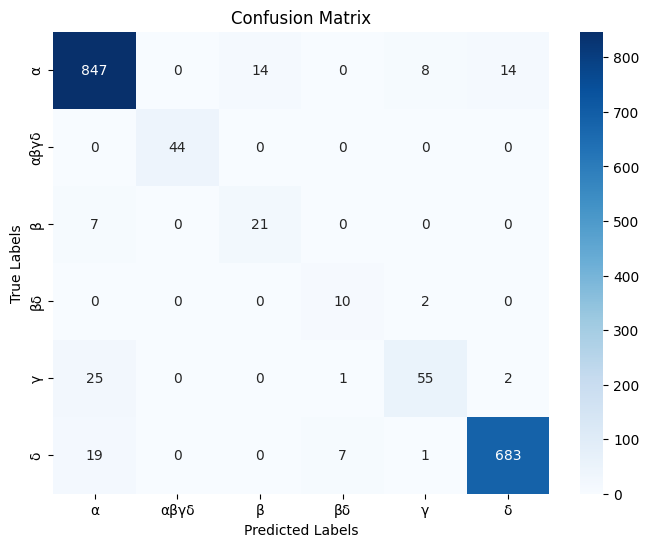

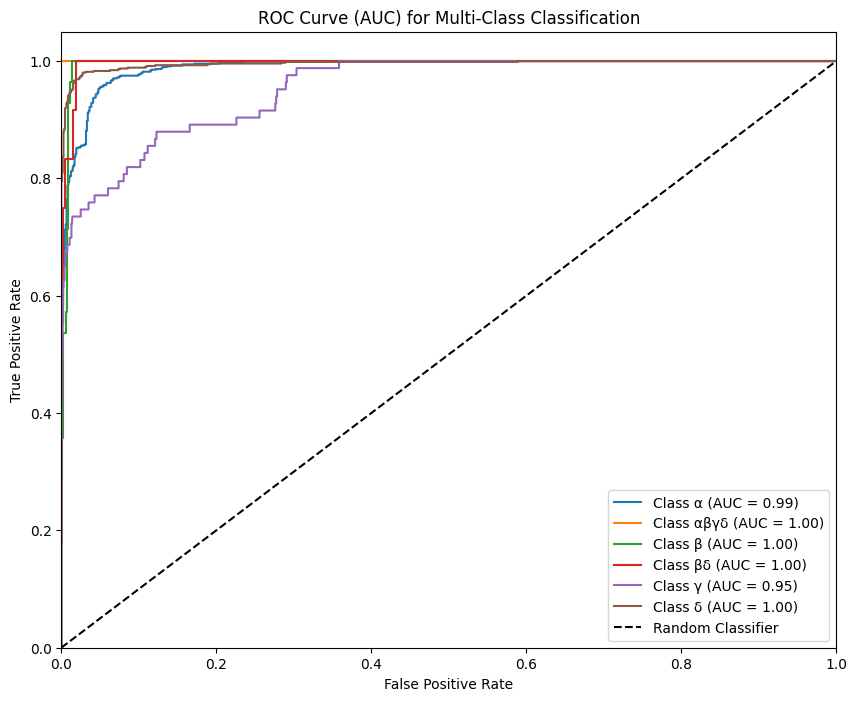

Results saved to D:\分类数据\XGboost推理能力.xlsx


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, auc
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import LabelBinarizer
from rdkit import Chem
from rdkit.Chem import AllChem

# SMILES 转特征的函数
def smiles_to_features(smiles_list):
    features = []
    for smi in smiles_list:
        # 跳过无效的 SMILES（例如 NaN 或 float）
        if isinstance(smi, str):
            mol = Chem.MolFromSmiles(smi)
            if mol is not None:
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
                features.append(fp)
            else:
                features.append(np.zeros(2048))  # 对无效的 SMILES 使用零向量
        else:
            features.append(np.zeros(2048))  # 对非字符串值使用零向量
    return np.array(features)

# 模型推理与结果保存
def model_inference(input_file, output_file):
    try:
        # 加载模型
        model = joblib.load('xgboost_model.pkl')
        label_encoder = joblib.load('label_encoder.pkl')

        # 读取输入数据
        inference_data = pd.read_excel(input_file)
        if 'smiles' not in inference_data.columns or 'labels' not in inference_data.columns:
            raise ValueError("输入文件必须包含 'smiles' 和 'labels' 列")

        smiles_list = inference_data['smiles']
        true_labels = inference_data['labels']

        # 转换SMILES为特征
        X_inference = smiles_to_features(smiles_list)

        # 预测
        y_pred = model.predict(X_inference)
        predicted_labels = label_encoder.inverse_transform(y_pred)

        # 确保真实标签格式正确
        if not np.array_equal(true_labels, label_encoder.inverse_transform(label_encoder.transform(true_labels))):
            print("警告: 真实标签格式可能与模型标签不一致")

        # 计算各类性能指标
        accuracy = accuracy_score(true_labels, predicted_labels)
        print(f"Inference Accuracy: {accuracy:.4f}")
        
        # 精确率、召回率、F1分数（宏观平均）
        precision = precision_score(true_labels, predicted_labels, average='macro')
        recall = recall_score(true_labels, predicted_labels, average='macro')
        f1 = f1_score(true_labels, predicted_labels, average='macro')
        print(f"Precision (Macro): {precision:.4f}")
        print(f"Recall (Macro): {recall:.4f}")
        print(f"F1 Score (Macro): {f1:.4f}")
        
        # 打印分类报告
        class_report = classification_report(true_labels, predicted_labels)
        print("Classification Report:")
        print(class_report)

        # 混淆矩阵
        conf_matrix = confusion_matrix(true_labels, predicted_labels)
        print("Confusion Matrix:")
        print(conf_matrix)

        # 绘制混淆矩阵图
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

        # ROC AUC（适用于二分类或者多标签分类）
        lb = LabelBinarizer()
        true_labels_bin = lb.fit_transform(true_labels)

        # 获取预测概率
        y_prob = model.predict_proba(X_inference)

        # 绘制每个类别的ROC曲线和AUC
        plt.figure(figsize=(10, 8))
        n_classes = y_prob.shape[1]
        fpr, tpr, roc_auc = {}, {}, {}

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], label=f'Class {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

        # 画对角线（随机分类器的ROC曲线）
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        # 保存ROC曲线数据到文件
        roc_data = pd.DataFrame({
        'Class': lb.classes_,
        'FPR': [fpr[i][-1] for i in range(n_classes)],
        'TPR': [tpr[i][-1] for i in range(n_classes)],
        'AUC': list(roc_auc.values())
        })
        
        roc_data.to_csv('D:\毕设文件2025.3.13\XGB_roc_data.csv', index=False)
        # 设置图形属性
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve (AUC) for Multi-Class Classification')
        plt.legend(loc='lower right')
        plt.show()

        # 保存结果
        inference_data['预测亚型'] = predicted_labels
        inference_data.to_excel(output_file, index=False)
        print(f"Results saved to {output_file}")

    except Exception as e:
        print(f"Error during inference: {e}")

# 示例推理调用
model_inference(r'D:\分类数据\0.1外部分类验证集.xlsx', 'D:\分类数据\XGboost推理能力.xlsx')


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
import numpy as np
import pandas as pd
import joblib

# SMILES 转特征的函数（假设已定义）
# def smiles_to_features(smiles_list):
#     # 假设这是一个有效的函数，将 SMILES 转换为特征矩阵
#     pass
def smiles_to_features(smiles_list):
    features = []
    for smi in smiles_list:
        # 跳过无效的 SMILES（例如 NaN 或 float）
        if isinstance(smi, str):
            mol = Chem.MolFromSmiles(smi)
            if mol is not None:
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
                features.append(fp)
            else:
                features.append(np.zeros(2048))  # 对无效的 SMILES 使用零向量
        else:
            features.append(np.zeros(2048))  # 对非字符串值使用零向量
    return np.array(features)

# 模型推理与结果保存
def model_inference(input_file, output_file):
    try:
        # 加载模型
        model = joblib.load('xgboost_model.pkl')
        label_encoder = joblib.load('label_encoder.pkl')

        # 读取输入数据
        inference_data = pd.read_excel(input_file)
        if 'smiles' not in inference_data.columns or 'labels' not in inference_data.columns:
            raise ValueError("输入文件必须包含 'smiles' 和 'labels' 列")

        smiles_list = inference_data['smiles']
        true_labels = inference_data['labels']

        # 转换SMILES为特征
        X_inference = smiles_to_features(smiles_list)

        # 预测
        y_pred = model.predict(X_inference)
        predicted_labels = label_encoder.inverse_transform(y_pred)

        # 确保真实标签格式正确
        if not np.array_equal(true_labels, label_encoder.inverse_transform(label_encoder.transform(true_labels))):
            print("警告: 真实标签格式可能与模型标签不一致")

        # 计算各类性能指标
        accuracy = accuracy_score(true_labels, predicted_labels)
        print(f"Inference Accuracy: {accuracy:.4f}")
        
        # 精确率、召回率、F1分数（宏观平均）
        precision = precision_score(true_labels, predicted_labels, average='macro')
        recall = recall_score(true_labels, predicted_labels, average='macro')
        f1 = f1_score(true_labels, predicted_labels, average='macro')
        print(f"Precision (Macro): {precision:.4f}")
        print(f"Recall (Macro): {recall:.4f}")
        print(f"F1 Score (Macro): {f1:.4f}")
        
        # 混淆矩阵
        conf_matrix = confusion_matrix(true_labels, predicted_labels)
        print("Confusion Matrix:")
        print(conf_matrix)
        
        # ROC AUC（适用于二分类或者多标签分类）
        # 这里需要模型输出概率，假设模型支持该输出
        # y_prob = model.predict_proba(X_inference)  # 如果模型支持预测概率
        # roc_auc = roc_auc_score(true_labels, y_prob, multi_class='ovr', average='macro')
        # print(f"ROC AUC: {roc_auc:.4f}")
        
        # 打印分类报告
        class_report = classification_report(true_labels, predicted_labels)
        print("Classification Report:")
        print(class_report)

        # 保存结果
        inference_data['预测亚型'] = predicted_labels
        inference_data.to_excel(output_file, index=False)
        print(f"Results saved to {output_file}")
        
    except Exception as e:
        print(f"Error during inference: {e}")

# 示例推理调用
model_inference(r'D:\分类数据\0.1外部分类验证集.xlsx', 'D:\分类数据\XGboost推理能力.xlsx')


[20:43:39] DEPRECATION WARNING: please use MorganGenerator
[20:43:39] DEPRECATION WARNING: please use MorganGenerator
[20:43:39] DEPRECATION WARNING: please use MorganGenerator
[20:43:39] DEPRECATION WARNING: please use MorganGenerator
[20:43:39] DEPRECATION WARNING: please use MorganGenerator
[20:43:39] DEPRECATION WARNING: please use MorganGenerator
[20:43:39] DEPRECATION WARNING: please use MorganGenerator
[20:43:39] DEPRECATION WARNING: please use MorganGenerator
[20:43:39] DEPRECATION WARNING: please use MorganGenerator
[20:43:39] DEPRECATION WARNING: please use MorganGenerator
[20:43:39] DEPRECATION WARNING: please use MorganGenerator
[20:43:39] DEPRECATION WARNING: please use MorganGenerator
[20:43:39] DEPRECATION WARNING: please use MorganGenerator
[20:43:39] DEPRECATION WARNING: please use MorganGenerator
[20:43:39] DEPRECATION WARNING: please use MorganGenerator
[20:43:39] DEPRECATION WARNING: please use MorganGenerator
[20:43:39] DEPRECATION WARNING: please use MorganGenerat

Inference Accuracy: 0.9432
Precision (Macro): 0.8182
Recall (Macro): 0.8612
F1 Score (Macro): 0.8320
Confusion Matrix:
[[847   0  14   0   8  14]
 [  0  44   0   0   0   0]
 [  7   0  21   0   0   0]
 [  0   0   0  10   2   0]
 [ 25   0   0   1  55   2]
 [ 19   0   0   7   1 683]]
Classification Report:
              precision    recall  f1-score   support

           α       0.94      0.96      0.95       883
        αβγδ       1.00      1.00      1.00        44
           β       0.60      0.75      0.67        28
          βδ       0.56      0.83      0.67        12
           γ       0.83      0.66      0.74        83
           δ       0.98      0.96      0.97       710

    accuracy                           0.94      1760
   macro avg       0.82      0.86      0.83      1760
weighted avg       0.95      0.94      0.94      1760

Results saved to D:\分类数据\XGboost推理能力.xlsx


In [14]:

# 6. 模型推理与结果保存
def model_inference(input_file, output_file):
    # 加载模型
    model = joblib.load('xgboost_model.pkl')
    label_encoder = joblib.load('label_encoder.pkl')

    # 读取输入数据
    inference_data = pd.read_excel(input_file)
    smiles_list = inference_data['smiles']
    

    # 转换SMILES为特征
    X_inference = smiles_to_features(smiles_list)

    # 预测
    y_pred = model.predict(X_inference)
    predicted_labels = label_encoder.inverse_transform(y_pred)

 
    # 保存结果
    inference_data['预测亚型'] = predicted_labels
    inference_data.to_excel(output_file, index=False)
    print(f"Results saved to {output_file}")

# 示例推理调用
model_inference(r"D:\天然产物的预测\预测出有活性的天然产物.xlsx", r"D:\天然产物的预测\预测出有活性的天然产物的催化亚型分类预测.xlsx")

[20:43:53] DEPRECATION WARNING: please use MorganGenerator
[20:43:53] DEPRECATION WARNING: please use MorganGenerator
[20:43:53] DEPRECATION WARNING: please use MorganGenerator
[20:43:53] DEPRECATION WARNING: please use MorganGenerator
[20:43:53] DEPRECATION WARNING: please use MorganGenerator
[20:43:53] DEPRECATION WARNING: please use MorganGenerator
[20:43:53] DEPRECATION WARNING: please use MorganGenerator
[20:43:53] DEPRECATION WARNING: please use MorganGenerator
[20:43:53] DEPRECATION WARNING: please use MorganGenerator
[20:43:53] DEPRECATION WARNING: please use MorganGenerator
[20:43:53] DEPRECATION WARNING: please use MorganGenerator
[20:43:53] DEPRECATION WARNING: please use MorganGenerator
[20:43:53] DEPRECATION WARNING: please use MorganGenerator
[20:43:53] DEPRECATION WARNING: please use MorganGenerator
[20:43:53] DEPRECATION WARNING: please use MorganGenerator
[20:43:53] DEPRECATION WARNING: please use MorganGenerator
[20:43:53] DEPRECATION WARNING: please use MorganGenerat

Results saved to D:\天然产物的预测\预测出有活性的天然产物的催化亚型分类预测.xlsx
